# 1. Import

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm
from datetime import datetime

# 2. Load Data

In [2]:
# load daily industry returns
df_daily = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios_Daily.CSV", index_col = 0)
df_daily.index = pd.to_datetime(df_daily.index, format = "%Y%m%d")
df_daily = df_daily / 100

# handle NA values
mask = (df_daily <= -0.99)
df_daily[mask] = np.nan

In [3]:
# load Fama French 3 Daily Factors
ff = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors_daily.CSV", index_col = 0)
ff.index = pd.to_datetime(ff.index, format = "%Y%m%d")
ff = ff / 100

# load Fama French 3 Monthly Factors
ff_monthly = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff_monthly.index = pd.to_datetime(ff_monthly.index, format = "%Y%m")
ff_monthly = ff_monthly / 100


# load 4 Monthly Fama French Factors (Mkt-RF, SMB, HML, MOM) and construct FF4 model
ff4 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff4.index = pd.to_datetime(ff4.index, format = "%Y%m")
ff4 = ff4 / 100

ff4_mom = pd.read_csv(str(Path().absolute()) + "/data/F-F_Momentum_Factor.CSV", index_col = 0)
ff4_mom.index = pd.to_datetime(ff4_mom.index, format = "%Y%m")
ff4_mom = ff4_mom / 100
ff4 = pd.concat([ff4, ff4_mom], axis = 1)
ff4 = ff4.dropna()


# load Fama French 5 Daily Factors
ff5 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_5_Factors_2x3.csv", index_col = 0)
ff5.index = pd.to_datetime(ff5.index, format = "%Y%m")
ff5 = ff5 / 100

In [4]:
# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
mask = (df <= -0.99)
df[mask] = np.nan

# nb of industries dataframe
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")
mask = (nb_industries <= -0.99)
nb_industries[mask] = np.nan

# average sizes dataframe
avg_size = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")
mask = (avg_size <= -0.99)
avg_size[mask] = np.nan

# sum of BE / sum of ME dataframe
be_over_me = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 4959, nrows = 99, header=0)
be_over_me.index = pd.to_datetime(be_over_me.index, format = "%Y")


# 3. Calculate Characteristics

## 3.1 Market Cap, Book-to-Market, Momentum

In [5]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# momentum with monthly data
momentum = df.rolling(12).mean()

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").ffill()

# need to add missing portion of 2024 since data with shifted index is missing it
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)
mask = (be_over_me <= -99.99)
be_over_me[mask] = np.nan

## 3.2 Beta

In [6]:
indices = pd.date_range("1926-07-30", "2024-12-31", freq = "M")
betas = pd.DataFrame(index=indices, columns=df_daily.columns)

for industry, industry_timeseries in tqdm(df_daily.items()):
    # skip first 12 months since we need a 12 month lookback window
    for i in range(12, len(indices)):
        
        # start and end date
        # this ensures ranges of the following form, for example: Sep 1 to Aug 31 
        start = indices[i-12] + pd.Timedelta(days = 1)
        end = indices[i]
        
        X = ff.loc[start:end,["Mkt-RF"]]
        y = industry_timeseries.loc[start:end] - ff.loc[start:end, "RF"]
        
        X = sm.add_constant(X)
        model = sm.OLS(y, X, missing='none').fit()
        beta = model.params["Mkt-RF"]
        betas.loc[end, industry] = beta
    
# convert the indices from month ends to starts of months
betas = betas.resample("MS").last()

48it [01:32,  1.93s/it]


## 3.3 Idiosyncratic Risk

In [7]:
# Get unique year-month pairs
monthly_periods = df_daily.resample('MS').mean().index

risk = pd.DataFrame(index=monthly_periods, columns=df_daily.columns)

for date in tqdm(monthly_periods):
    # filter data for the entire month
    mask = (df_daily.index.year == date.year) & (df_daily.index.month == date.month)
    ret_data = df_daily[mask]
    factors_data = ff[mask]
    
    for industry, industry_timeseries in ret_data.items():
            
            # ensure aligned data
            aligned_data = pd.concat([industry_timeseries, factors_data], axis = 1)
            
            X = aligned_data.loc[:,["Mkt-RF", "SMB", "HML"]].values
            y = (aligned_data.loc[:, industry] - aligned_data.loc[:, "RF"]).values
            
            X = sm.add_constant(X)
            model = sm.OLS(y, X, missing='none').fit()

            # calculate standard error (volatility) of residuals
            risk.loc[date, industry] = np.sqrt(model.mse_resid)
            

100%|██████████| 1182/1182 [00:58<00:00, 20.11it/s]


In [8]:
risk

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-01,0.011329,0.004672,NaN,0.010478,0.003043,0.021013,0.004853,0.040741,0.006796,0.010027,...,0.011716,0.002909,0.03956,0.004048,0.006323,0.011049,0.003921,0.00614,0.011151,0.012044
1926-08-01,0.005359,0.003672,NaN,0.022384,0.005105,0.033688,0.004817,0.040075,0.006025,0.00928,...,0.006683,0.003541,0.047961,0.004196,0.006865,0.021243,0.007485,0.008656,0.011685,0.016783
1926-09-01,0.006307,0.003657,NaN,0.011554,0.003686,0.025639,0.006816,0.032463,0.007992,0.010385,...,0.007305,0.002976,0.048186,0.005441,0.004852,0.009183,0.006051,0.007812,0.006203,0.00843
1926-10-01,0.011631,0.002669,NaN,0.019821,0.004155,0.016202,0.007796,0.019837,0.00598,0.011828,...,0.008187,0.002313,0.03903,0.006462,0.00635,0.015243,0.004514,0.011929,0.010506,0.010168
1926-11-01,0.011683,0.003095,NaN,0.010193,0.004529,0.021021,0.003876,0.032847,0.006545,0.011729,...,0.007599,0.001239,0.031569,0.005382,0.006274,0.018704,0.007599,0.008458,0.010587,0.020054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.007927,0.007907,0.008832,0.007506,0.010015,0.006491,0.006364,0.008481,0.008741,0.00727,...,0.007049,0.00652,0.005671,0.007991,0.006493,0.003339,0.005354,0.006592,0.00519,0.004474
2024-09-01,0.006873,0.005699,0.007845,0.007732,0.008998,0.006221,0.007404,0.007594,0.00662,0.011859,...,0.005112,0.007672,0.006107,0.005958,0.00469,0.006049,0.005591,0.007369,0.004403,0.005151
2024-10-01,0.00894,0.00483,0.007506,0.006881,0.018445,0.006849,0.014464,0.006713,0.005533,0.01065,...,0.008123,0.006325,0.005508,0.00513,0.005647,0.002629,0.006563,0.01286,0.004889,0.006317


## 3.4 Long-Short Portfolios

In [9]:
def long_short_portfolio_char(df: pd.DataFrame, mkt_cap: pd.DataFrame, characteristic: pd.DataFrame, char_name: str):
    """
    Calculates the returns of a long-short portfolio where the 5 highest characteristic companies are bought
    and the 5 lowest characteristic companies are sold, with allocations based on market weights and equal weight.
    ---
    :param df: DataFrame of underlying industry returns
    :param mkt_cap: DataFrame of market cap of each company
    :param characteristic: DataFrame of characteristic values of each industry
    :param char_name: Name of the characteristic to input in column names
    :return: pandas Series of returns of the long-short portfolio
    """

    # preallocate memory to data frame to store results
    results = pd.DataFrame(index = characteristic.index[1:], columns = [char_name + " Value Weight", char_name + " Equal Weight"], dtype="float")

    for i in range(len(characteristic) - 1):
        # Get characteristic values for the current period
        current_characteristic = characteristic.iloc[i]
        
        # Sort companies by characteristic
        sorted_characteristic = current_characteristic.sort_values(ascending=False)
        
        # Select the 5 highest and 5 lowest companies by their characteristic value
        highest_char_ind = sorted_characteristic.dropna().head(5)
        lowest_char_ind = sorted_characteristic.dropna().tail(5)
        
        # Calculate market weights
        long_weights_mkt = mkt_cap.iloc[i][highest_char_ind.index] / mkt_cap.iloc[i][highest_char_ind.index].sum()
        short_weights_mkt = mkt_cap.iloc[i][lowest_char_ind.index] / mkt_cap.iloc[i][lowest_char_ind.index].sum()
        
        # Calculate equal weights
        equal_weights = np.full(5, 1/5)

        # Get returns for the next period
        next_returns = df.iloc[i + 1]
        
        # handle case where indices might contain NaNs
        if (highest_char_ind.isna().any() or lowest_char_ind.isna().any()):
            results.iloc[i, 0] = np.nan
            results.iloc[i, 1] = np.nan

        # handle case where all values are NaN
        if (highest_char_ind.index.empty or lowest_char_ind.index.empty):
            results.iloc[i, 0] = np.nan
            results.iloc[i, 1] = np.nan

        else:
            # Calculate value-weighted portfolio return
            long_return = (next_returns[highest_char_ind.index] * long_weights_mkt).sum()
            short_return = (next_returns[lowest_char_ind.index] * short_weights_mkt).sum()
            portfolio_return_mkt = long_return - short_return

            # Calculate equal-weighted portfolio return
            long_return = (next_returns[highest_char_ind.index] * equal_weights).sum()
            short_return = (next_returns[lowest_char_ind.index] * equal_weights).sum()
            portfolio_return_eq = long_return - short_return

            results.iloc[i, 0] = portfolio_return_mkt
            results.iloc[i, 1] = portfolio_return_eq

    return results

In [12]:
# conduct backtests for each characteristic
portfolio_returns_btm = long_short_portfolio_char(df, mkt_cap, be_over_me, "BE Over ME")
portfolio_returns_mkt = long_short_portfolio_char(df, mkt_cap, mkt_cap, "Market Cap")
portfolio_returns_mom = long_short_portfolio_char(df, mkt_cap, momentum, "Momentum")
portfolio_returns_betas = long_short_portfolio_char(df, mkt_cap, betas, "Beta")
portfolio_returns_risks = long_short_portfolio_char(df, mkt_cap, risk, "Idiosyncratic Risk")

portfolio_results = pd.concat([portfolio_returns_btm, portfolio_returns_mkt, portfolio_returns_mom, portfolio_returns_betas, portfolio_returns_risks], axis = 1)

# 3.5 Long-Short Portfolio Results

<Figure size 1200x600 with 0 Axes>

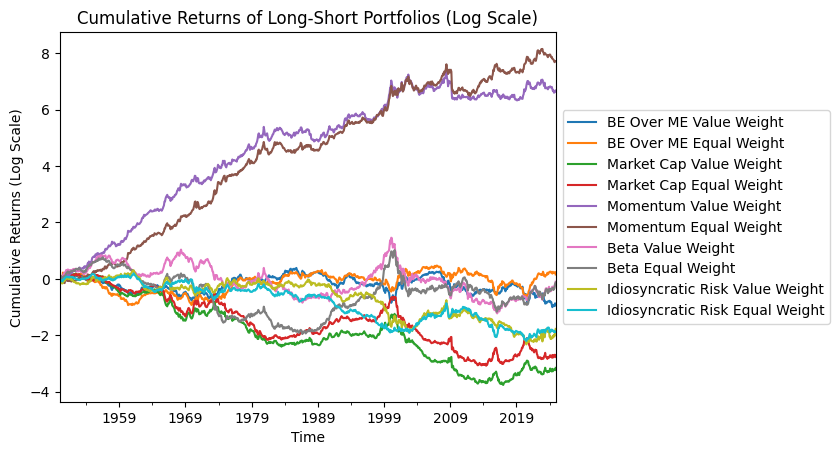

In [13]:
# Resize the plot
plt.figure(figsize=(12, 6))  # Adjust the figure size (width, height)

# Plot the data
np.log((1 + portfolio_results.loc["1950":]).cumprod()).plot()

# Relocate the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust legend position
plt.title("Cumulative Returns of Long-Short Portfolios (Log Scale)")  # Add the title
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (Log Scale)")
# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

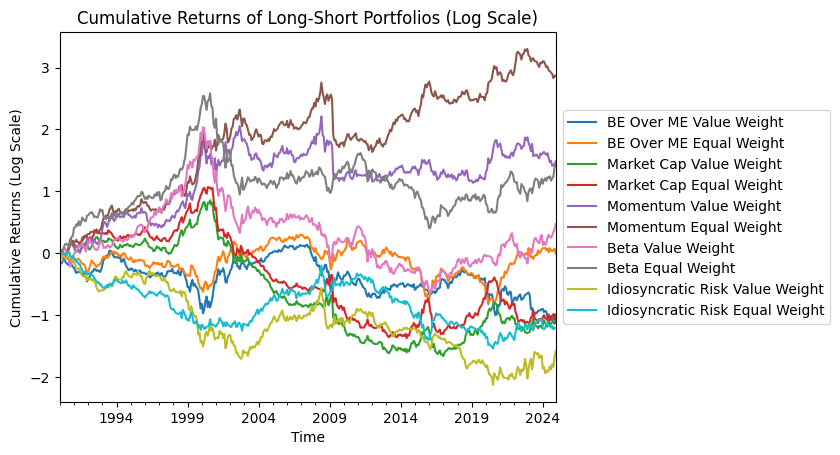

In [14]:
# Resize the plot
plt.figure(figsize=(12, 6))  # Adjust the figure size (width, height)

# Plot the data
np.log((1 + portfolio_results.loc["1990":]).cumprod()).plot()

# Relocate the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust legend position
plt.title("Cumulative Returns of Long-Short Portfolios (Log Scale)")  # Add the title
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (Log Scale)")
# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

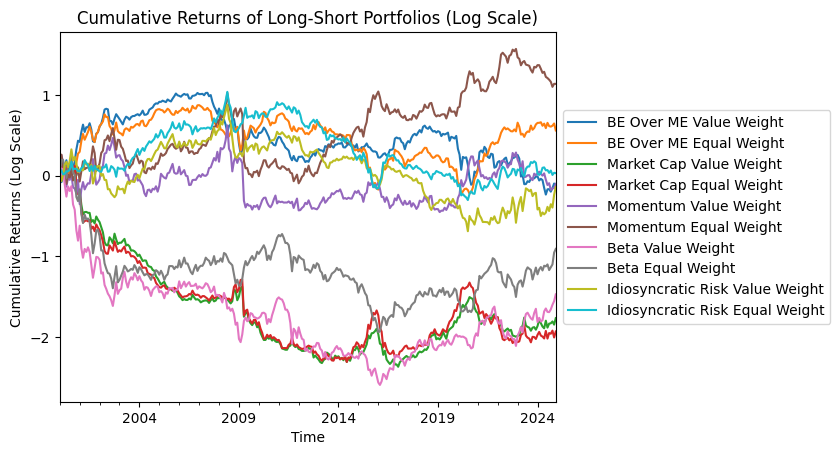

In [15]:
 # Resize the plot
plt.figure(figsize=(12, 6))  # Adjust the figure size (width, height)

# Plot the data
np.log((1 + portfolio_results.loc["2000":]).cumprod()).plot()

# Relocate the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust legend position
plt.title("Cumulative Returns of Long-Short Portfolios (Log Scale)")  # Add the title
plt.xlabel("Time")
plt.ylabel("Cumulative Returns (Log Scale)")
# Show the plot
plt.show()

# 4. Annualized Performance Measures

In [16]:
def mean_return(rets: pd.DataFrame):
    """
    calculates the annualized mean return of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :return: float of the annualized mean return
    """
    avg_ret = 12 * rets.mean()

    return avg_ret


def sharpe_ratio(rets: pd.DataFrame, rf: pd.DataFrame):
    """
    calculates the annualized sharpe ratio of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param rf: pandas Series/DataFrame of risk-free rate
    :return: float of the annualized sharpe ratio
    """

    sharpe = np.sqrt(12) * (rets - rf).mean() / rets.std()  # use excess returns
    return sharpe


def alpha(rets: pd.DataFrame, ff: pd.DataFrame):
    """
    calculates the annualized Jensen's Alpha by OLS regression of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param ff: pandas DataFrame of Fama French factors
    :return: float of the annualized alpha of the strategy
    """

    ff = ff.values
    ff = sm.add_constant(ff)
    model = sm.OLS(rets, ff, missing='none').fit()

    return 12 * model.params["const"]

def alpha_p_val(rets: pd.DataFrame, ff: pd.DataFrame):
    """
    calculates the p value of Jensen's Alpha obtained by OLS regression of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param ff: pandas DataFrame of Fama French factors
    :return: float of the p value of the alpha obtained
    """

    ff = ff.values
    ff = sm.add_constant(ff)
    model = sm.OLS(rets, ff, missing='none').fit()

    return model.pvalues["const"]

In [17]:
# list of periods to consider to calculate alpha
start_date = [datetime(year = 1950, month = 1, day = 1), datetime(year = 1990, month = 1, day = 1), datetime(year = 2000, month = 1, day = 1)]
results = [np.nan, np.nan, np.nan]

for i in range(len(start_date)):
    
    # select current period for backtest results
    start = start_date[i]
    mask = (portfolio_results.index >= start)
    current_portfolio = portfolio_results[mask]
    
    # select current periods for fama french factors
    current_ff3 = ff_monthly.loc[ff_monthly.index >= start, ["Mkt-RF", "SMB", "HML", "RF"]]
    current_ff4 = ff4.loc[ff4.index >= start, ["Mkt-RF", "SMB", "HML", "Mom   ", "RF"]]
    current_ff5 = ff5.loc[(ff5.index >= max(start, datetime(1963, 7, 1))), ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]]  # need to recall that the data begins in 1963 for fama french 5 factor model

    # calculate mean returns and sharpe ratios for each long-short portfolio
    mean_rets= current_portfolio.apply(mean_return, axis = 0)
    sharpe_ratios = current_portfolio.apply(lambda x: sharpe_ratio(x, current_ff3["RF"]), axis = 0)

    # compute alpha of each long-short portfolio against fama french 3 factor model
    alpha_ff3 = current_portfolio.apply(lambda x: alpha(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)
    p_vals_ff3 = current_portfolio.apply(lambda x: alpha_p_val(x - current_ff3["RF"], current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)

    # compute alpha of each long-short portfolio against fama french 4 factor model
    alpha_ff4 = current_portfolio.apply(lambda x: alpha(x - current_ff4["RF"], current_ff4[["Mkt-RF", "SMB", "HML", "Mom   "]]), axis = 0)
    p_vals_ff4 = current_portfolio.apply(lambda x: alpha_p_val(x - current_ff4["RF"], current_ff4[["Mkt-RF", "SMB", "HML", "Mom   "]]), axis = 0)
    
    # compute alpha of each long-short portfolio against fama french 5 factor model
    # we must also ensure that the data begins in 1963 for the portfolio returns since the 5 factor model data begins then
    current_portfolio_ff5 = current_portfolio.loc[(current_portfolio.index >= datetime(1963, 7, 1))]
    alpha_ff5 = current_portfolio_ff5.apply(lambda x: alpha(x - current_ff5["RF"], current_ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]), axis = 0)
    p_vals_ff5 = current_portfolio_ff5.apply(lambda x: alpha_p_val(x - current_ff5["RF"], current_ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]), axis = 0)

    # save results
    results[i] = pd.concat([mean_rets, sharpe_ratios, alpha_ff3, p_vals_ff3, alpha_ff4, p_vals_ff4, alpha_ff5, p_vals_ff5], axis = 1)
    results[i].columns = ["Mean Return", "Sharpe Ratio", "Alpha 3 Factor Fama French", "P-Value of Alpha 3 Factor Fama French", "Alpha 4 Factor Fama French", "P-Value of Alpha 4 Factor Fama French", "Alpha 5 Factor Fama French", "P-Value of Alpha 5 Factor Fama French"]
    

In [18]:
# merge and display results
results = {'Jul1931-Dec2025': results[0], 'Jan1990-Dec2025': results[1], 'Jan2000-Dec2025': results[2]}
results = pd.concat(results, axis = 0)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
results

Mean Return  Sharpe Ratio  \
Jul1931-Dec2025 BE Over ME Value Weight               0.0005       -0.2412   
                BE Over ME Equal Weight               0.0136       -0.1703   
                Market Cap Value Weight              -0.0304       -0.4629   
                Market Cap Equal Weight              -0.0231       -0.3957   
                Momentum Value Weight                 0.1110        0.3459   
                Momentum Equal Weight                 0.1225        0.4291   
                Beta Value Weight                     0.0200       -0.0941   
                Beta Equal Weight                     0.0175       -0.1122   
                Idiosyncratic Risk Value Weight      -0.0085       -0.2772   
                Idiosyncratic Risk Equal Weight      -0.0147       -0.3801   
Jan1990-Dec2025 BE Over ME Value Weight              -0.0124       -0.2059   
                BE Over ME Equal Weight               0.0140       -0.0733   
                Market Cap Value Weight              -0.0161       -0.2556   
                Market Cap Equal Weight              -0.0114       -0.2089   
                Momentum Value Weight                 0.0724        0.1903   
                Momentum Equal Weight                 0.1086        0.3648   
                Beta Value Weight                     0.0440        0.0714   
                Beta Equal Weight                     0.0697        0.1815   
                Idiosyncratic Risk Value Weight      -0.0238       -0.2441   
                Idiosyncratic Risk Equal Weight      -0.0210       -0.2879   
Jan2000-Dec2025 BE Over ME Value Weight               0.0135       -0.0210   
                BE Over ME Equal Weight               0.0392        0.1174   
                Market Cap Value Weight              -0.0539       -0.4018   
                Market Cap Equal Weight              -0.0568       -0.3795   
                Momentum Value Weight                 0.0305        0.0493   
                Momentum Equal Weight                 0.0766        0.2424   
                Beta Value Weight                    -0.0255       -0.1687   
                Beta Equal Weight                    -0.0041       -0.0864   
                Idiosyncratic Risk Value Weight       0.0185        0.0037   
                Idiosyncratic Risk Equal Weight       0.0168       -0.0048   

                                                 Alpha 3 Factor Fama French  \
Jul1931-Dec2025 BE Over ME Value Weight                             -0.0887   
                BE Over ME Equal Weight                             -0.0739   
                Market Cap Value Weight                             -0.0374   
                Market Cap Equal Weight                             -0.0260   
                Momentum Value Weight                                0.0917   
                Momentum Equal Weight                                0.1061   
                Beta Value Weight                                   -0.0637   
                Beta Equal Weight                                   -0.0680   
                Idiosyncratic Risk Value Weight                     -0.0679   
                Idiosyncratic Risk Equal Weight                     -0.0699   
Jan1990-Dec2025 BE Over ME Value Weight                             -0.0684   
                BE Over ME Equal Weight                             -0.0468   
                Market Cap Value Weight                             -0.0254   
                Market Cap Equal Weight                             -0.0153   
                Momentum Value Weight                                0.0731   
                Momentum Equal Weight                                0.1115   
                Beta Value Weight                                   -0.0530   
                Beta Equal Weight                                   -0.0295   
                Idiosyncratic Risk Value Weight                     -0.0719   
                Idiosyncratic Risk Equal Weight   

# 5. Investigate HML Factor

Text(0, 0.5, 'Cumulative Log Returns')

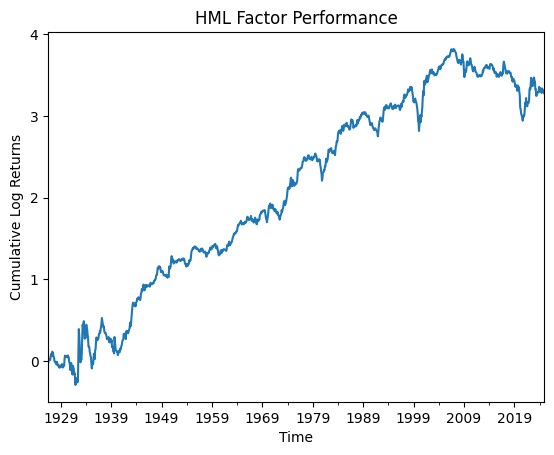

In [20]:
np.log((ff_monthly["HML"] + 1).cumprod()).plot()
plt.title("HML Factor Performance")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Returns")